![twitter](https://www.crained.com/wp-content/uploads/2020/01/Screen-Shot-2020-01-19-at-12.19.40-PM.png)

**Importing Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import emoji
import os
import sys
import fasttext
import re
import nltk 

from nltk.corpus import stopwords
import tensorflow as tf
tf.keras.backend.clear_session()

import itertools
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


![twitter](https://media2.s-nbcnews.com/j/newscms/2018_05/2314116/180201-twitter-logo-ac-702p_c7d1da2f557bd5d16b23618cfcd702d6.fit-760w.jpg)

![twitter](https://cloverchronicle.com/wp-content/uploads/2019/04/Obama-Clinton-Twitter-Easter-Worshippers-Muslim-Community.png)

**Reading Dataset**

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
subm = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')


**Basic EDA**

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
print("For Training Set")
for col in train.columns:
    print("% of nan in ",col," - ",train[col].isna().sum()/train.shape[0])

For Training Set
% of nan in  id  -  0.0
% of nan in  keyword  -  0.008012610009194798
% of nan in  location  -  0.33272034677525286
% of nan in  text  -  0.0
% of nan in  target  -  0.0


In [6]:
print("For Test Set")
for col in test.columns:
    print("% of nan in ",col," - ",test[col].isna().sum()/test.shape[0])

For Test Set
% of nan in  id  -  0.0
% of nan in  keyword  -  0.00796812749003984
% of nan in  location  -  0.3386454183266932
% of nan in  text  -  0.0


**Exploring Target Column**

In [7]:
import plotly.express as px

# df = px.data.target()
fig = px.parallel_categories(train)

fig.show()

1 represents Disasterous Tweets whereas 0 represents Non-Disastrous

*Disaster tweets are Less in Number as compared to Non Disaster Tweets*

**Basic Data Preprocessing**

The following workflow is followed:
* Remove HTML
* Remove Emoji's + contractions
* Remove punctuation
* Tokenization + Remove  stopwords
* Lemmatization 





In [8]:
#remove url
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [9]:
import re
def remove_URLs(text):
    url = re.compile(r'http?://\S+|www\.\S+')
    return url.sub(r'',text)

In [10]:
train['text'] = train['text'].apply(remove_URL)
test['text'] = test['text'].apply(remove_URL)

In [11]:
train['text'] = train['text'].apply(remove_URLs)
test['text'] = test['text'].apply(remove_URLs)

In [12]:
#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [13]:
train['text'] = train['text'].apply(remove_emoji)
test['text'] = test['text'].apply(remove_emoji)

In [14]:
#remove contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [15]:
def remove_contractions(text):
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [16]:
train['text']=train['text'].apply(remove_contractions)
test['text']=test['text'].apply(remove_contractions)

In [17]:
#remove punctuation
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [18]:
train['text'] = train['text'].apply(remove_punct)
test['text'] = test['text'].apply(remove_punct)


In [19]:
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 

In [20]:
tweets_train = train['text'].values
target = train['target'].values

tweets_test = test['text'].values

**Removing Stopwords**

We imported a list of the most frequently used words from the NL Toolkit at the beginning with from nltk.corpus import stopwords.There are 179 English words, including ‘i’, ‘me’, ‘my’, ‘myself’, ‘we’, ‘you’, ‘he’, ‘his’, for example. We usually want to remove these because they have low predictive power. There are occasions when you may want to keep them though. Such as, if your corpus is very small and removing stop words would decrease the total number of words by a large percent.
![stopwords](https://media.geeksforgeeks.org/wp-content/cdn-uploads/Stop-word-removal-using-NLTK.png)

**Lemmatizing the text**

Lemmatizing, maps common words into one base. Unlike stemming though, it always still returns a proper word that can be found in the dictionary
![lemmatizing](https://cdn-images-1.medium.com/max/1600/1*z4f7My5peI28lNpZdHk_Iw.png)

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

**Constructing Custom Stop Word Lists**

In [22]:
#Most common words
freq = pd.Series(' '.join(train['text']).split()).value_counts()[:20]
freq

the     2595
a       1874
to      1815
in      1777
of      1731
and     1313
I       1225
for      825
is       824
on       790
you      666
The      581
my       549
with     518
that     515
at       491
it       487
by       472
be       376
from     373
dtype: int64

In [23]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(train 
         ['text']).split()).value_counts()[-20:]
freq1

InfiniteGrace7    1
ideals            1
visible           1
Gaping            1
reader            1
patio             1
AAR               1
Northbound        1
volcanotornado    1
timebomb          1
Daughtery         1
Nah               1
WHELEN            1
Columbus          1
Lanford           1
stopping          1
flex              1
EseVU             1
BOBBYXFISHER      1
typewriter        1
dtype: int64

In [24]:
thislist = ['were', 'the', 'amp', 'dont', 'got', 'know', 'gon', 'na', 'wan', 'like', 'im', 'hers', 'why', 'over', "'d",'our', 'these', 'nevertheless', 'its', 'them', 'empty', 'how', 'whereas', 'whether', 'fifteen', 'about', 'four', 'give', 'otherwise', 'move', 'do', 'say', '‘ve', 'hence', 'n‘t', 'between', 'bottom', 'some', 'against', 'whole', 'i', 'into', 'they', 'already', 'she', 'either', 'an', 'both', 'him', 'due', 'using', 'five', 'across', 'front', 'in', 'off', 'only', 'really', 'twelve', 'twenty', 'show', 'whereupon', '‘m', 'n’t', 'himself', '’m', 'from', 'often', 'three', 'various', 'thereupon', 'should', 'put', 'take', 'who', 'above', 'their', 'been', 'towards', 'however', "n't", 'her', 'go', 'thereby', 'just', 'yourselves', 'become', 'thru', 'while', 'nowhere', 'neither', 'anyway', 'because', 'ca', 'which', 'moreover', 'forty', 'besides', 'us', 'more', 'third', 'wherein', 'whoever', 'used', 'every', 'whose', 'onto', 'your', 'hereafter', 'itself', 'sometimes', 'name', 'too', 'own', 'somewhere', 'there', 'we', 'you', '’ve', 'ourselves', 'sixty', 'would', 'first', 'must', 'whereafter', 'wherever', 'his', 'around', 'has', 'yours', 'became', 'doing','the', 'below', 'then', 'everyone', 'else', 'any', 'latterly', 'noone', 'part', 'might', "'ve", 'becoming', 'same', 'top', 'yourself', 'he', 'each', 'anyone', 'my', 'seeming', 'six', 'the', 'during', 'afterwards', 'throughout', 'formerly', 'seem', 'therefore', 'another', 'keep', 'without', 'being', 'can', 'had', 'per', "'s", 'other', 'side', '’s', 'also', 'herself', '’ll', 'eight', 'what', 'please', 'a', 'therein', 'back', 'me', 'never', 'not', 'does', 'enough', 'meanwhile', 'toward', 'even', 'get', 'and', 'it', 'perhaps', 'this', 'regarding', 'somehow', 'cannot', 'anyhow', 'through', 'whenever', 'thereafter', 'rather', 'by', 'still', 'where', 'than', 'made', 'of', 'will', 'within', 'are', 'amongst', 'although', 'former', 'full', 'nobody', 'was', 'to', 'is', 'at', 'hundred', 'all', 'on', 'such', 'after', 'almost', 'most', 'no', 'our', 'see', 'thus', 'upon', "'ll", 'whence', 'make', '‘s', 'could', 'quite', 'or', 'beyond', 'thence', 'mostly', 'though', 'alone', 'for', 'under', 'seemed', 'until', 'much', 'nine', 'least', 'that', 'nor', 'further', 'themselves', 'whatever', 'whom', 'anywhere', 'myself', 'eleven', 'none', 'with', 'as', 'have', '‘ll', "'m", 'up', 'if', 'several', 'whereby', 'now', 'always', 'amount', 'done', 'hereupon', 'others', 'may', 'one', 'everything', 'so', 'hereby', 'anything', 'fifty', 'last', 'am', 'beforehand', 'few', 'ever', 'together', 'unless', 'ten', 'behind', 'when', 'those', 'mine', 'everywhere', 'be', 'less', 'nothing', 'something', 'very', "'re", 'here', '‘re', 'since', 'seems', 'down', 'did', 'before', 'serious', '‘d', '’d', 'many', 'call', 'along', 'once', 'herein', 'out', 'namely', 'someone', 'becomes', 'whither', 're', 'two', 'but', 'again', 'elsewhere', 'well', 'next', 'sometime', 'indeed', 'ours', 'yet', '’re', 'via', 'latter', 'except', 'among', 'beside']


In [25]:
stop_words.update(thislist)

In [26]:
for i in range(len(tweets_train)):
    
    sentences = sent_tokenize(tweets_train[i])
    
    word_list = []
    for sent in sentences:
        
        words = word_tokenize(sent)
        
        for word in words:
            
            if words not in word_list:
                word_list.append(word)
                
    
    word_list = [lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]
    
    tweets_train[i] = ' '.join(w for w in word_list)

In [27]:
for i in range(len(tweets_test)):
    
    sentences = sent_tokenize(tweets_test[i])
    
    word_list = []
    for sent in sentences:
        
        words = word_tokenize(sent)
        
        for word in words:
            
            if words not in word_list:
                word_list.append(word)
                
    
    word_list = [lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]
    
    tweets_test[i] = ' '.join(w for w in word_list)


**Visualization**

<Figure size 720x432 with 0 Axes>

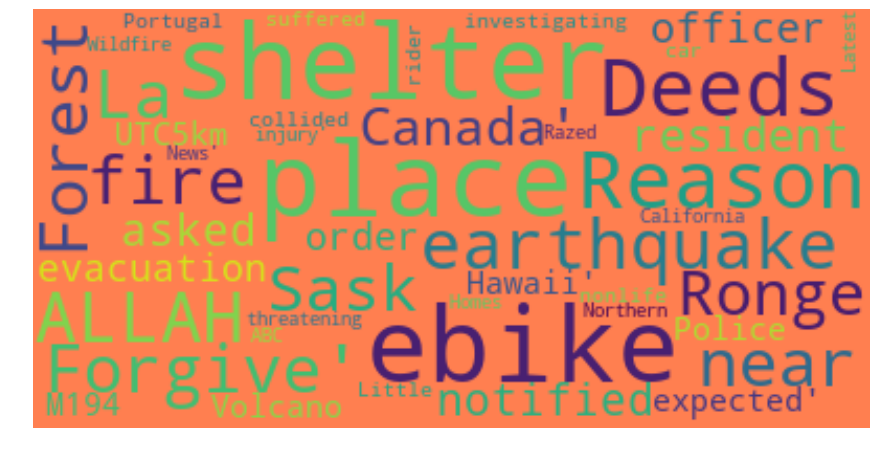

In [28]:
wordcloud = WordCloud(background_color='coral',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(tweets_train))
plt.figure(figsize=(10,6))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

In [29]:
#Combined statistical representations with px.histogram

train_ = train[train['keyword'].notna()]
train__ = train_[train_['location'].notna()]
import plotly.express as px
# df = px.data.tips()
fig = px.histogram(train__, x="id", y="text", color="target", marginal="rug",
                   hover_data=train__.columns)
fig.show()

In [30]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(tweets_train)
list(cv.vocabulary_.keys())[:10]


['deeds',
 'reason',
 'earthquake',
 'allah',
 'forgive',
 'forest',
 'fire',
 'near',
 'la',
 'canada']

**Advance Data Preprocessing**

* N-grams
* Term frequency
* Inverse Document Frequency
* Term Frequency – Inverse Document Frequency (TF-IDF)

**N-Grams**

N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one. The longer the n-gram (the higher the n), the more context you have to work with. Optimum length really depends on the application – if your n-grams are too short, you may fail to capture important differences. On the other hand, if they are too long, you may fail to capture the “general knowledge” and only stick to particular cases.

In [31]:
m = list(train['text'].values)

Unigram

In [32]:
#Most frequently occuring words
def get_top_n_words(m, n=None):
#     vec = CountVectorizer().fit(m)
    bag_of_words = cv.transform(m)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(m, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
top_df.head()
#Barplot of most freq words
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
# g = sns.barplot(x="Word", y="Freq", data=top_df)
# g.set_xticklabels(g.get_xticklabels(), rotation=30)

,Word,Freq
0,fire,340
1,new,226
2,people,198
3,news,193
4,video,173


In [33]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=top_df['Freq'].tolist(),
            y=top_df['Word'].tolist(),
            orientation='h'))

fig.show()

Bi-grams

In [34]:
#Most frequently occuring Bi-grams
def get_top_n2_words(m, n=None):
    vec1=CountVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(2,2)).fit(m)
#     vec1 = CountVectorizer(ngram_range=(2,2),  
#             max_features=2000).fit(m)
    bag_of_words = vec1.transform(m)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(m, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
# #Barplot of most freq Bi-grams
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
# h=sns.boxplot(y="Bi-gram", x="Freq", data=top2_df)
# h.set_yticklabels(h.get_yticklabels(), rotation=0)

                Bi-gram  Freq
0        suicide bomber    60
1      burning building    52
2         youtube video    43
3         liked youtube    42
4              body bag    42
5   northern california    41
6            cross body    39
7             oil spill    39
8   california wildfire    35
9       suicide bombing    34
10          mass murder    33
11     natural disaster    30
12        prebreak best    30
13     bomber detonated    30
14            heat wave    29
15      confirmed mh370    29
16        mass murderer    28
17       razed northern    28
18             16yr old    28
19          pkk suicide    28


[Text(0, 0, 'suicide bomber'),
 Text(0, 0, 'burning building'),
 Text(0, 0, 'youtube video'),
 Text(0, 0, 'liked youtube'),
 Text(0, 0, 'body bag'),
 Text(0, 0, 'northern california'),
 Text(0, 0, 'cross body'),
 Text(0, 0, 'oil spill'),
 Text(0, 0, 'california wildfire'),
 Text(0, 0, 'suicide bombing'),
 Text(0, 0, 'mass murder'),
 Text(0, 0, 'natural disaster'),
 Text(0, 0, 'prebreak best'),
 Text(0, 0, 'bomber detonated'),
 Text(0, 0, 'heat wave'),
 Text(0, 0, 'confirmed mh370'),
 Text(0, 0, 'mass murderer'),
 Text(0, 0, 'razed northern'),
 Text(0, 0, '16yr old'),
 Text(0, 0, 'pkk suicide')]

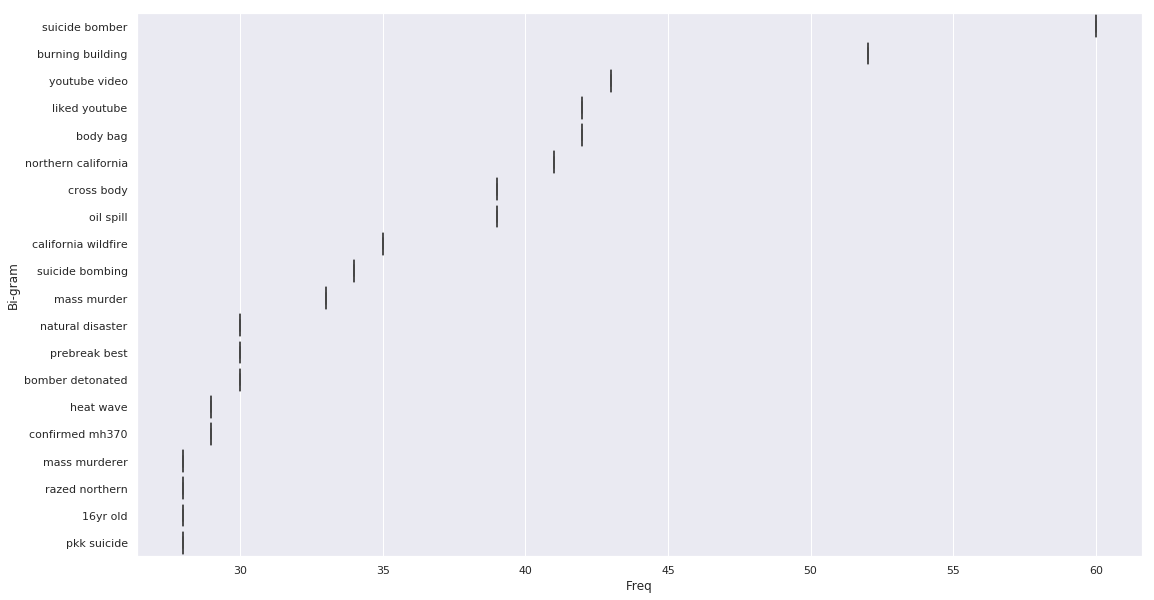

In [35]:
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(18,10)})
h=sns.boxplot(y="Bi-gram", x="Freq", data=top2_df)
h.set_yticklabels(h.get_yticklabels(), rotation=0)

Tri-grams

In [36]:
def get_top_n3_words(m, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(m)
    bag_of_words = vec1.transform(m)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(m, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

                               Tri-gram  Freq
0                   liked youtube video    42
1              suicide bomber detonated    30
2          northern california wildfire    29
3                       the latest more    28
4                    pkk suicide bomber    28
5                 bomber detonated bomb    28
6             razed northern california    27
7                          16yr old pkk    27
8                       old pkk suicide    27
9             families sue legionnaires    26
10                       more 40 family    26
11                   40 family affected    26
12                family affected fatal    26
13              affected fatal outbreak    26
14              obama declares disaster    25
15  declares disaster typhoondevastated    25
16    disaster typhoondevastated saipan    25
17                sue legionnaires more    25
18                 legionnaires more 40    25
19      wreckage conclusively confirmed    25


In [37]:
import plotly.express as px

# df = px.data.gapminder().query("continent == 'Europe' and year == 2007 and pop > 2.e6")
fig = px.bar(top3_df,x="Tri-gram", y="Freq")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

**Term frequency**
Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.

Therefore, we can generalize term frequency as:

TF = (Number of times term T appears in the particular row) / (number of terms in that row)

To understand more about Term Frequency, have a look at [this article](https://www.analyticsvidhya.com/blog/2015/04/information-retrieval-system-explained/).

Below, I have tried to show you the term frequency table of a tweet.



In [38]:
tf1 = (train['text'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,Canada,1
1,Ronge,1
2,La,1
3,Sask,1
4,near,1
5,fire,1
6,Forest,1


**Inverse Document Frequency**
The intuition behind inverse document frequency (IDF) is that a word is not of much use to us if it’s appearing in all the documents.

Therefore, the IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

So, let’s calculate IDF for the same tweets for which we calculated the term frequency.

In [39]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['text'].str.contains(word)])))

tf1

,words,tf,idf
0,Canada,1,6.635027
1,Ronge,1,8.937613
2,La,1,3.396349
3,Sask,1,8.937613
4,near,1,4.426753
5,fire,1,2.989578
6,Forest,1,5.326695


**Term Frequency – Inverse Document Frequency (TF-IDF)**
TF-IDF is the multiplication of the TF and IDF which we calculated above.



In [40]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,Canada,1,6.635027,6.635027
1,Ronge,1,8.937613,8.937613
2,La,1,3.396349,3.396349
3,Sask,1,8.937613,8.937613
4,near,1,4.426753,4.426753
5,fire,1,2.989578,2.989578
6,Forest,1,5.326695,5.326695


In [41]:
import re
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=tokenize)
train_vec = vectorizer.fit_transform(tweets_train)

In [43]:
test_vec = vectorizer.transform(tweets_test)

In [44]:
print(train_vec.shape,test_vec.shape)

(7613, 17479) (3263, 17479)


**Building a Text Classification model**

Now the data is ready to be fed into a classification model. Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

In [45]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
clf = linear_model.RidgeClassifier()

In [46]:
scores = model_selection.cross_val_score(clf, train_vec, train["target"], cv=3, scoring="f1")
scores

array([0.60971524, 0.54200542, 0.65777322])

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
lr = LogisticRegression(C=2, dual=True,solver='liblinear',max_iter=5000)


In [49]:
lr.fit(train_vec,target)

LogisticRegression(C=2, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
scores = model_selection.cross_val_score(lr, train_vec, train["target"], cv=5, scoring="f1")
scores

array([0.59390364, 0.54545455, 0.57015986, 0.5030426 , 0.71322925])

In [51]:
lr.fit(train_vec, train["target"])

LogisticRegression(C=2, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
subm["target"] = lr.predict(test_vec)

In [53]:
subm.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [54]:
subm.to_csv("submission.csv", index=False)